# ATM 552 Capstone - North Pacific EOF
Liam Kirkpatrick
Starting Feb 10, 2023



## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## User Inputs
Set basic choices for the rest of the code

In [2]:
# path to data
dpath = '../data/'

# min and max year
yrmin = 1950
yrmax = 2023

# toggle diagnostic plots on/off
plot_diag = True

# toggle remove ann cycle on/off
rem_anncycle = True

# make date vectors
date = pd.date_range(str(yrmin)+'-01-01',str(yrmax)+'-12-01', 
              freq='MS')
years = pd.date_range(str(yrmin)+'-01-01',str(yrmax)+'-12-01', 
              freq='YS')
month_names = ['J','F','M','A','M','J','J','A','S','O','N','D']

## Import Data
- Read in data from csv files
- Filter for correct years within range as numpy array

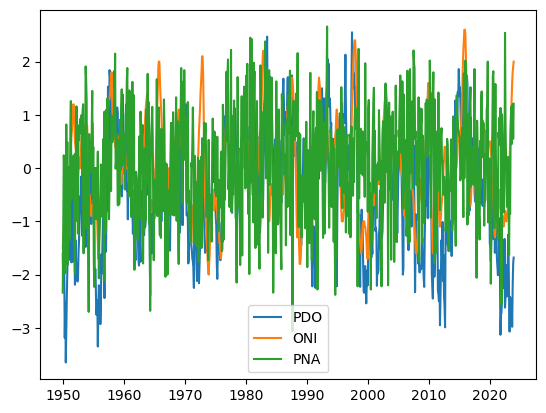

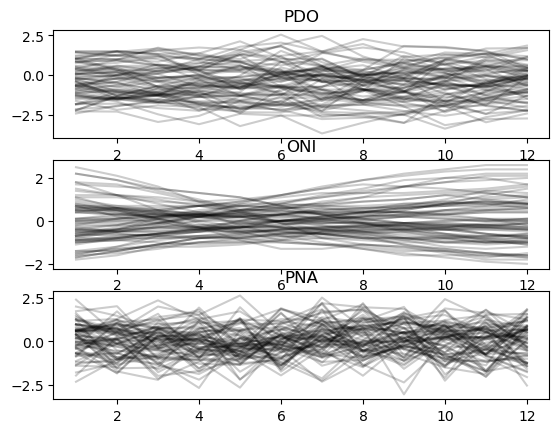

In [3]:
# define function
def basicimport(fname,dpath,yrmin,yrmax):

    # read in data as pandas dataframe
    df = pd.read_csv(dpath+fname)

    # sort out years
    df_yrs = df.loc[(df['Year'] >=yrmin) & (df['Year'] <= yrmax)]

    # drop years column
    df_yrs = df_yrs.drop(['Year'],axis=1)

    return df_yrs.to_numpy()

# run for all
pdo = basicimport('pdo.csv',dpath,yrmin,yrmax)
pna = basicimport('pna.csv',dpath,yrmin,yrmax)
oni = basicimport('oni.csv',dpath,yrmin,yrmax)
#sia = basicimport('bering_SIA.csv',dpath,yrmin,yrmax)

# make a list of all data
data = [pdo,oni,pna]
data_names = ['PDO','ONI','PNA']

# make a test plot
if plot_diag:

    fig,ax = plt.subplots(1)
    for d,n in zip(data,data_names):
        ax.plot(date,d.flatten(),label=n)
    ax.legend()

    fig2,ax2 = plt.subplots(len(data))
    months = [1,2,3,4,5,6,7,8,9,10,11,12]
    for i in range(len(data)):

        arr = data[i]
        
        for j in range(len(arr)):
            ax2[i].plot(months,arr[j,:],'k',alpha=0.2)
        ax2[i].set_title(data_names[i])
    

## Behind-the-scenes bookkeeping

In [4]:

# number of timesteps
mnx = len(pdo)

## Clean Data - remove annual cycle

[-0.31418919 -0.33337838 -0.41743243 -0.46756757 -0.46716216 -0.37932432
 -0.51297297 -0.585      -0.55445946 -0.49148649 -0.42932432 -0.34337838]
[-0.03108108 -0.02972973 -0.02297297 -0.01081081 -0.0027027   0.01351351
  0.02702703  0.03243243  0.03513514  0.04054054  0.02972973  0.01891892]
[ 0.1977027   0.00716216 -0.03743243 -0.06567568 -0.16054054 -0.05905405
  0.26743243  0.1922973   0.19891892  0.07527027 -0.02594595  0.06594595]


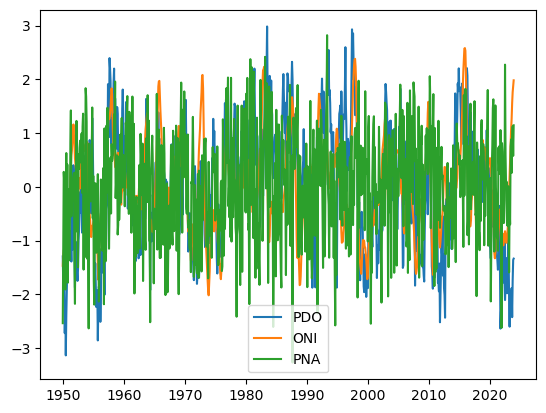

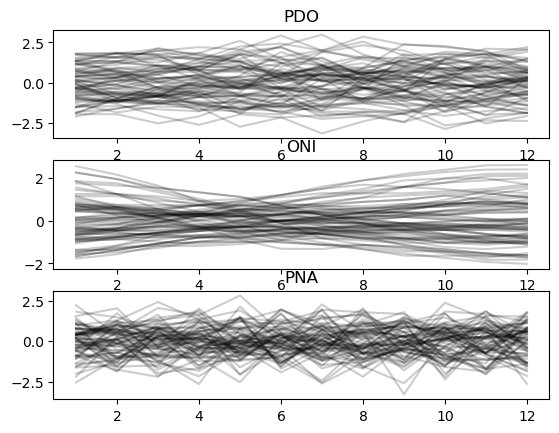

In [5]:
# define annual cycle removing function
def rem_anncycle(ar):

    # Calculate average for each month
    ave = np.mean(ar,axis=0)
    print(ave)

    # make empty array
    a,b = np.shape(ar)
    for i in range(a):
        for j in range(b):
            ar[i,j] = ar[i,j] - ave[j]

    return(ar)

# Loop through and apply to all arrays
if rem_anncycle:
    data1 = []
    for i in range(len(data)):
        data1.append(rem_anncycle(data[i]))
else:
    data1 = data

# divide by standard deviation
for i in range(len(data)):
    #data1.append(np.divide(data2[i],np.std(data2[i])))
    np.divide(data1[i],np.std(data1[i]))
    
if plot_diag:

    # plot all
    fig,ax = plt.subplots(1)
    for d,n in zip(data1,data_names):
        ax.plot(date,d.flatten(),label=n)
    ax.legend()

    # plot ann cycle
    fig,ax = plt.subplots(len(data1))
    months = [1,2,3,4,5,6,7,8,9,10,11,12]
    for i in range(len(data1)):

        arr = data1[i]
        
        for j in range(len(arr)):
            ax[i].plot(months,arr[j,:],'k',alpha=0.2)
        ax[i].set_title(data_names[i])

## Convert to appropriate format for EOF analysis

In [6]:
# start off the EOF master array with the first of the index members
datax = data[0]

# add each of the remaining members
for i in data[1:]:
    print(np.shape(i))
    datax = np.concatenate((datax,i),axis=1)

(74, 12)
(74, 12)


In [7]:
def autocorr2(x,lags):
    '''manualy compute, non partial'''
    
    mean=np.nanmean(x)
    var=np.nanvar(x)
    if var == 0.0:
        var=1.0e-6
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags] #corr=[ np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]
    return np.array(corr)
    
xcor = np.zeros([2])

nt, ns = np.shape(datax)
print('nt',nt,'ns',ns)
type(ns)
lags = [0,1]
for i in range(ns):
    xx=np.squeeze(datax[:,i])
    xcor1 = autocorr2(xx,lags)
    xcor = xcor + xcor1
    

xcor = xcor/float(ns)
acorr = xcor[1]
dof = mnx*(1. - acorr**2)/(1. + acorr**2)

print('DOF = ',dof,',   DOF/mnx = ',dof/mnx,',  mnx = ',mnx)

nt 74 ns 36
DOF =  72.17340105534457 ,   DOF/mnx =  0.9753162304776293 ,  mnx =  74


## Preform EOF Analysis

In [8]:
# do some matrix math!
u, s, vh = np.linalg.svd(datax.T)
print('u shape',np.shape(u))

u shape (36, 36)


u shape (36, 36)
vh shape (74, 74)
s shape (36,)


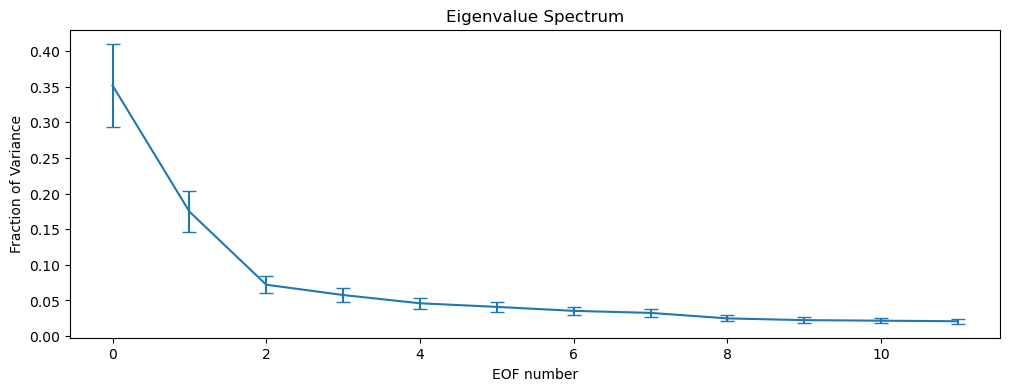

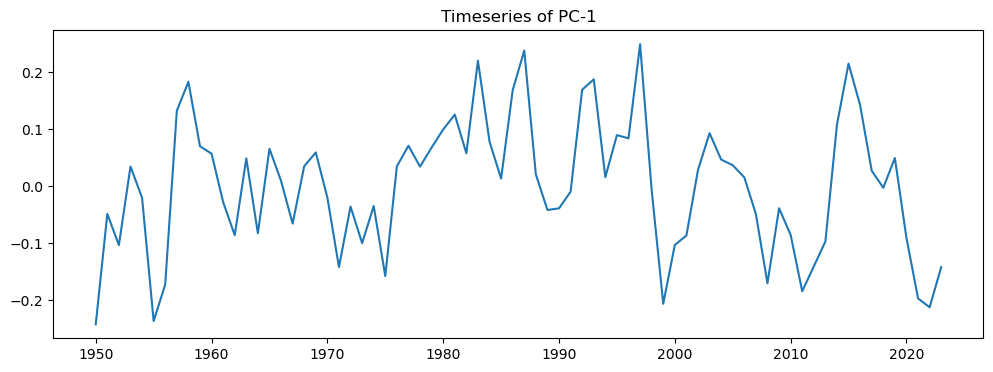

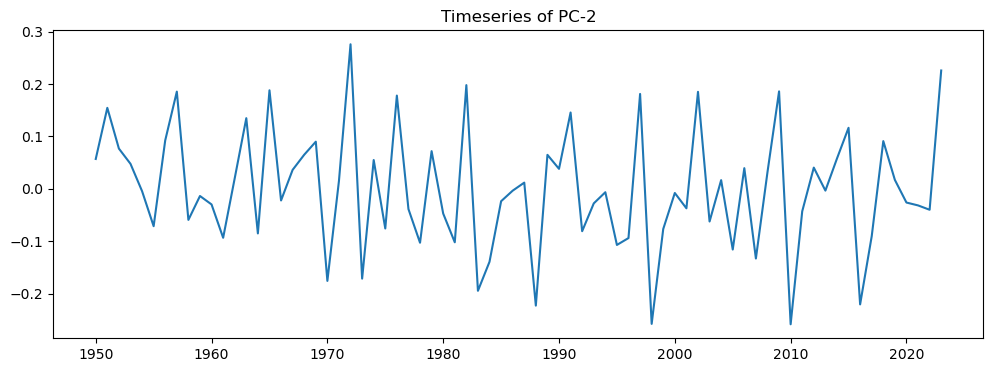

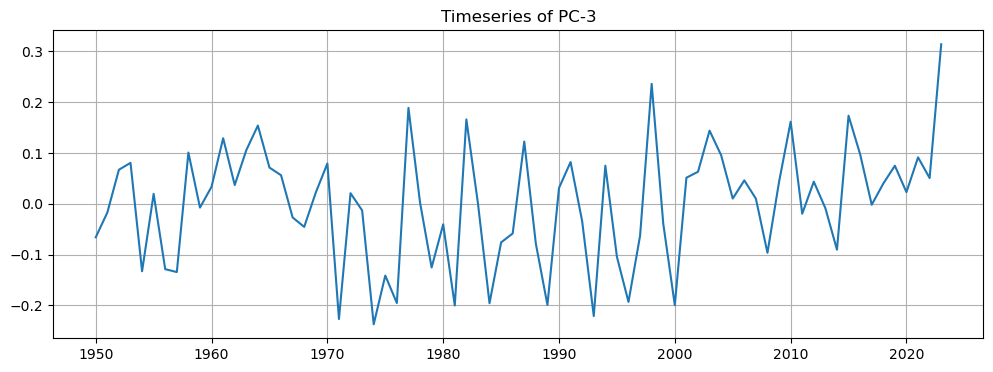

In [9]:
print('u shape',np.shape(u))
print('vh shape',np.shape(vh))
print('s shape',np.shape(s))
type(u)
type(vh)
type(s)
spectrum = s*s.T
spectrum = spectrum/sum(spectrum)

pcmx = 3

plt.figure(figsize=(12, 4), dpi=100)
yerror = spectrum*np.sqrt(2/dof)
index = np.linspace(0,24,25)
plt.errorbar(index[0:12],spectrum[0:12],yerror[0:12],capsize=5)
plt.ylabel('Fraction of Variance')
plt.xlabel('EOF number')
plt.title('Eigenvalue Spectrum')
# We need to construct the EOF map by regressing the pc onto the original data pcmx=4 # were going to consider the first 4 eofs
ts = vh[0:pcmx,:] # hope this is time series of first eof, YES looks right,␣ ↪has autocorrelation
for pci in range(0,pcmx):
    plt.figure(figsize=(12, 4), dpi=100)
    plt.plot(years,ts[pci,:])
    plt.title('Timeseries of PC-' + str(pci+1))
plt.grid()

## Regress onto original data

In [10]:
len(date)# here we attempt the regression:  we need to go back and get the original data

# here we attempt the regression:  we need to go back and get the original data

# Make empty regression vector
regm = np.empty([pcmx+1,12*len(data)])

# Loop through each PC
for pci in range(0,pcmx):

    # extract the t vector for this PC
    t=ts[pci,:]

    # normalize predictor to have one standard deviation
    t = t/np.std(t)  

    # compute regression (t*ssb)/mnx
    reg = np.matmul(t,datax)/mnx

    # save this regression
    regm[pci,:] = reg

## Plot Individual EOFs

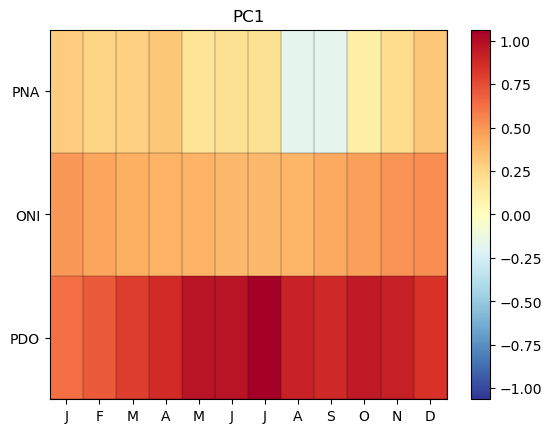

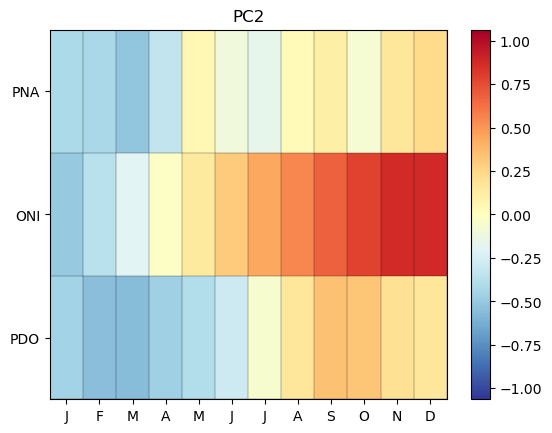

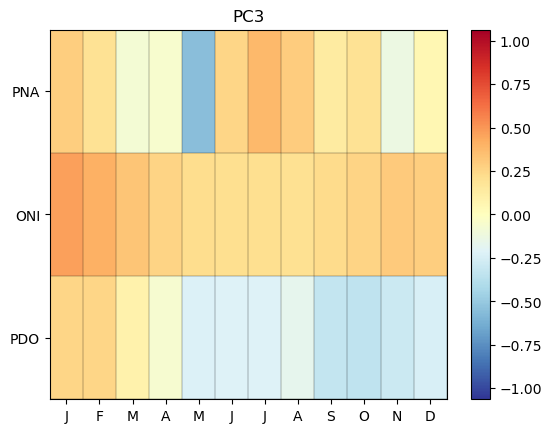

In [11]:
# plot book keeping
nrows = len(data)
ncols = 12
x = np.arange(ncols + 1)-0.5
y = np.arange(nrows + 1)-0.5

cmap = 'RdYlBu_r'

# Loop through each PC
for ip in range(0,pcmx):

    # here I am finding the maximum value, fixing colors accross plots
    regm1 = regm[ip,:]
    if ip == 0:  # same contour interval for all plots
        rmax = np.nanmax(np.abs(regm1))
        nconts=60
        contr = np.linspace(-rmax,rmax,nconts+1)
        
    fig, ax = plt.subplots()

    Z = regm[ip,:].reshape(nrows,ncols)
    pcm = ax.pcolormesh(x, y, Z, shading='flat', vmin=-rmax, vmax=rmax,cmap=cmap)
    ax.set_yticks(range(len(data_names)),data_names)
    ax.set_xticks(range(len(month_names)),month_names)

    # plot lines
    for i in x:
        ax.plot([i, i],[min(y),max(y)],'k',linewidth=0.2)
    for i in y:
        ax.plot([min(x), max(x)],[i,i],'k',linewidth=0.2)

    fig.colorbar(pcm,orientation='vertical')
    ax.set_title('PC'+str(ip+1))
            
